In [1]:
import serial
import struct
import time
import numpy as np
import os
from serial.tools.list_ports import comports

def read_number(msg):
    return int(input(msg))

def read_port(msg):
    port = input(msg)
    #index = input(msg)
    #port = "COM8";
    return serial.Serial(port, 9600)

            
def print_until_keyword(keyword, device):
    while True: 
        msg = device.serial.readline().decode()
        if msg[:-2] == keyword: break
        #else: print(f'({arduino.port}):',msg, end='')
            
def read_matrix(device, dimms):
    result = np.zeros((1,dimms)).reshape(-1)
    for i in range(dimms):
        device.serial.read()
        result[i] = struct.unpack('f', device.serial.read(4))[0]
    
    return result.reshape(dimms)

clear = lambda: os.system('clear')

In [2]:
class Device:
    def __init__(self, serial):
        self.serial = serial
        self.weights = []
        self.metalayers = []
        self.gradients = []
        
    def set_weights(self, weights):
        self.weights = weight
        
    def set_metadata(self, metalayer):
        self.metalayer = metalayer
        
def getDevices():
    num_devices = read_number("Number of devices: ")
    # num_devices = 2

    available_ports = comports()
    print("Available ports:")
    for available_port in available_ports: print(available_port)

    devices = [read_port(f"Port device_{i+1}: ") for i in range(num_devices)]
    list_devices = []
    for device in devices:
        list_devices.append(Device(device))
    return list_devices

class Layer:
    def __init__(self, layer_type):
        self.layer_type = layer_type
        
    def __repr__(self):
        return f"{self.layer_type}"
    
class Dense(Layer):
    def __init__(self, rows, cols):
        super().__init__("Dense")
        self.rows = rows
        self.cols = cols
        
    def __repr__(self):
        return f"{self.layer_type=} {self.rows=} {self.cols=}"
    
class MaxPooling(Layer):
    def __init__(self, r, c, ch):
        super().__init__("MaxPooling")
        self.rows = r
        self.cols = c
        self.ch = ch
        
    def __repr__(self):
        return f"{self.layer_type}  - {self.rows=} {self.cols=} {self.ch=}"
    
class Conv2D(Layer):
    def __init__(self, kh, kw, c, kc):
        super().__init__("Conv2D")
        self.kh = kh
        self.kw = kw
        self.c = c
        self.kc = kc
        
    def __repr__(self):
        return f"{self.layer_type=} - {self.kh=} {self.kw=} {self.c=} {self.kc=}"
        

In [3]:
# Send the blank model to all the devices
def receive_model_info(device):
    device.serial.reset_input_buffer()
    device.serial.write(b's') # Python --> ACK --> Arduino
    print_until_keyword('start', device) # CLEAN SERIAL
    
    bytesToRead = device.serial.read(1).decode()
    time.sleep(1)
    if bytesToRead == 'i':
        device.serial.write(struct.pack('f', LEARNING_RATE))
        [num_layers] = struct.unpack('i', device.serial.read(4))
        layers = []
        for i in range(num_layers):
            [layer_type] = struct.unpack('i', device.serial.read(4))
            if layer_type == -1:
                [rows, cols] = struct.unpack('ii', device.serial.read(8))
                layers.append(Dense(rows, cols))
            elif layer_type == -2:
                [rows, cols, ch] = struct.unpack('iii', device.serial.read(12))
                layers.append(MaxPooling(rows,cols,ch))
            elif layer_type == -3:
                [kh, kw, c, kc] = struct.unpack('iiii', device.serial.read(16))
                layers.append(Conv2D(kh,kw,c,kc))
            # dimms.append((1,cols)) # bias
            # dimms.append((rows,cols)) # matrix weigths
        device.metalayers = layers
    return num_layers, layers


In [4]:
import random    
## RECEIVE MODEL WEIGHT
def get_device_weights(device, bias_dimm, w_dimm):
    number_of_floats = w_dimm[0] * w_dimm[1]
    weights = np.zeros(w_dimm).reshape(-1)
    for i in range(number_of_floats):
        device.serial.read()
        weights[i] = struct.unpack('f', device.serial.read(4))[0]
        
    number_of_floats = bias_dimm[0] * bias_dimm[1]
    bias = np.zeros(bias_dimm).reshape(-1)
    for i in range(number_of_floats):
        device.serial.read()
        bias[i] = struct.unpack('f', device.serial.read(4))[0]
    
    return weights.reshape(w_dimm), bias.reshape(bias_dimm)
    
def get_device_weights_cnn(device, kh, kw, c, kc):
    in_size = kh * kw * c
    out_size = kh * kw * kc
    weights = np.zeros((kh, kw, c, kc)).reshape(-1)
    for i,w in enumerate(weights.reshape(-1)):
        device.serial.read()
        weights[i] = struct.unpack('f', device.serial.read(4))[0]
            
    bias = np.zeros((1,kc)).reshape(-1)
    for i,b in enumerate(bias.reshape(-1)):
        device.serial.read()
        bias[i] = struct.unpack('f', device.serial.read(4))[0]
    
    return weights.reshape((kh, kw, c, kc)), bias.reshape((1,kc))

def get_device_weights_pool(device, rows, cols, ch):
    weights = np.random.randn(rows, cols, ch).reshape(-1)
    for i,w in enumerate(weights.reshape(-1)):
        device.serial.read()
        weights[i] = struct.unpack('f', device.serial.read(4))[0]
    
    return weights.reshape((rows, cols, ch))
    

In [5]:
bias = np.zeros((5, 5, 1, 8)).reshape(-1).reshape(-1)

print(bias.shape)

(200,)


In [21]:

def initialize_device_weights(device, bias_dimm, w_dimm):
    np.random.seed(42)
    random.seed(42)
    bias = np.zeros(bias_dimm)
    weights = np.random.randn(w_dimm[0], w_dimm[1]) * np.sqrt(6.0 / (w_dimm[0] + w_dimm[1]))
    return weights, bias
    device.serial.write(struct.pack('f'*bias.reshape(-1).shape[0], *bias.reshape(-1)))

    #for w in weights.reshape(-1):
    #   data = device.serial.read()
    device.serial.write(struct.pack('f'*weights.reshape(-1).shape[0], *weights.reshape(-1)))
    
def initialize_device_weights_cnn(device, kh, kw, c, kc):
    np.random.seed(42)
    random.seed(42)
    bias = np.zeros((1,kc))
    in_size = kh * kw * c
    out_size = kh * kw * kc
    weights = np.random.randn(kh, kw, c, kc) * np.sqrt(6.0 / (in_size + out_size))
    return weights, bias
    print(f"Sending weights for layer Conv2D")
    #for b in bias.reshape(-1):
        #data = device.serial.read()
    device.serial.write(struct.pack('f'* bias.reshape(-1).shape[0], *bias.reshape(-1)))

    #for w in weights.reshape(-1):
    #   data = device.serial.read()
    device.serial.write(struct.pack('f' * weights.reshape(-1).shape[0], *weights.reshape(-1)))

def create_initial_model(device, layers):
    weights = []
    for layer in layers:
        if layer.layer_type == "Conv2D":
            weights.append(initialize_device_weights_cnn(device, layer.kh, layer.kw, layer.c, layer.kc))
        elif layer.layer_type == "Dense":
            weights.append(initialize_device_weights(device, (1,layer.cols), (layer.rows,layer.cols)))
        else:
            weights.append((np.array([]), np.array([])))
    return weights

    
def send_initial_weights(device, global_model):
    for weights, bias in global_model:
        #print(weights.shape, bias.shape)
        device.serial.write(struct.pack('f' * bias.reshape(-1).shape[0], *bias.reshape(-1)))
        device.serial.write(struct.pack('f' * weights.reshape(-1).shape[0], *weights.reshape(-1)))
    

In [7]:
def send_weights(device, weights, layer):
    bias = weights[1]
    weights = weights[0]
    #print(f"Sending bias for Dense {bias.reshape(-1).shape} {device.serial.port}")
    #for b in bias.reshape(-1):
        #data = device.serial.read()
        #device.serial.write(struct.pack('f', b))
    if layer.layer_type != 'MaxPooling':
        device.serial.write(struct.pack('f' * bias.reshape(-1).shape[0],*bias.reshape(-1)))
        device.serial.write(struct.pack('f' * weights.reshape(-1).shape[0], *weights.reshape(-1)))

    #print(f"Sending weights for Dense {weights.reshape(-1).shape} {device.serial.port}")
    #for w in weights.reshape(-1):
        #data = device.serial.read()
        
def send_model_weights(device, weights):
    layers = device.metalayers
    device.serial.write(b'r')
 
    for i, layer in enumerate(weights):
        send_weights(device, weights[i], layers[i])

    #print(f"{device.serial.port} weights initialized!")

In [10]:
def get_model_weights(device):
    layers = device.metalayers
    device.serial.write(b'g') # Python --> ACK --> Arduino
    device.weights = []

    for i, layer in enumerate(layers):
        if layer.layer_type == "Conv2D":
            weights, biases = get_device_weights_cnn(device, layer.kh, layer.kw, layer.c, layer.kc)
            device.weights.append((weights, biases))
        elif layer.layer_type == "Dense":
            weights, biases = get_device_weights(device, (1,layer.cols), (layer.rows,layer.cols))
            device.weights.append((weights, biases))
        elif layer.layer_type == "MaxPooling":
            #weights = get_device_weights_pool(device, layer.rows,layer.cols, layer.ch)
            device.weights.append((weights, np.array([])))
    #print(f"Model weight received!")

    
def get_model_gradients(device):
    layers = device.metalayers
    device.serial.write(b'g') # Python --> ACK --> Arduino
    device.gradients = []
    
    for i, layer in enumerate(layers):
        if layer.layer_type == "Conv2D":
            weights, biases = get_device_weights_cnn(device, layer.kh, layer.kw, layer.c, layer.kc)
            device.gradients.append((weights, biases))
        elif layer.layer_type == "Dense":
            weights, biases = get_device_weights(device, (1,layer.cols), (layer.rows,layer.cols))
            device.gradients.append((weights, biases))
        elif layer.layer_type == "MaxPooling":
            #weights = get_device_weights_pool(device, layer.rows,layer.cols, layer.ch)
            device.gradients.append((np.array([]), np.array([])))
    #print(f"Model weight received!")


In [16]:
def send_sample(device, X, y=None):
    if IS_KEYWORD_SPOTTING:
        #for i,k in enumerate(X.reshape(-1)):
            #device.serial.write(struct.pack('f',k))
            #print("SENT XX",i)
        device.serial.write(struct.pack('h' * X.reshape(-1).shape[0], *X.reshape(-1)))
    else:
        device.serial.write(struct.pack('f' * X.reshape(-1).shape[0], *X.reshape(-1)))

        #for i,k in enumerate(X.reshape(-1)):
            #raw = device.serial.read(4)
            #j = struct.unpack('i', raw)[0]
            #device.serial.write(struct.pack('f',k))
            #print("SENT",j, i)
            #print(f"returned error = {raw}")

    #print(f"Want to send y={y.shape}")
    if y is not None:
        device.serial.write(struct.pack('f' * y.reshape(-1).shape[0], *y.reshape(-1)))
        #for i, t in enumerate(y.reshape(-1)):
            #device.serial.read()
            #device.serial.write(struct.pack('f', t))
        #print(f"Sample y = {y.shape} sent!")

def get_tick():
    return time.time_ns()

def train(device, X, y, size=1):
    error = 0.0
    for i in range(size):
        if i%100 == 0:
            print(f"{i}/{size} Done")
        device.serial.write(b"t")
        send_sample(device, X[i], y[i].reshape(1,TARGET_SIZE))
        #print("SAMPLE SENT")

        start = get_tick()
        n_error = device.serial.read(4)
        #print(f"returned error = {n_error}")
        end = get_tick()
        loss = struct.unpack('f', n_error)[0]
        error += loss
    return end-start, error/size

def predict(device, X, y):
    device.serial.write(b"p")
    send_sample(device, X, y.reshape(1,TARGET_SIZE))
    # read last layer size output
    # Target size + 1 for the loss value
    start = get_tick()
    output = read_matrix(device, TARGET_SIZE+1)
    return get_tick() - start, output[:-1], output[-1]


- call getDevices() to obtain all conected devices
- asks the user how many devices you want to use
- send the initial model for every device
- create thread for every device
    - send samples and start training for one epoch
- wait for all threads to finish
- FEDERATED LEARNING
- create thread for every device and receive models
- permute the average of every layer
- create thread for every device and receive models
- send back the models

In [12]:
def fl(devices):
    # RECEIVE MODELS
    #print("Receiving models from devices...")
    threads = []
    for device in devices:
        thread = threading.Thread(target=get_model_weights, args=(device,))
        thread.daemon = True
        thread.start()
        threads.append(thread)

    for thread in threads: thread.join() # Wait for all the threads to end
    #print("Models received")
    # AVERAGE MODELS
    num_layers = len(devices[0].metalayers)
    assert num_layers > 0, "NO LAYERS!"

    #accuracies = fl_info_infer[-2]['accuracy']
    #total_accuracy = sum(accuracies.values())
    #normalized_accuracies = [accuracy / total_accuracy for accuracy in accuracies.values()]
    #print(normalized_accuracies)
    list_weights = []
    for i in range(0, num_layers):
        weights, bias = devices[0].weights[i]
        weights = np.zeros_like(weights)
        bias = np.zeros_like(bias)
        for k,device in enumerate(devices):
            weights += device.weights[i][0]
            bias += device.weights[i][1]
        
        list_weights.append((weights,bias))

    for i,(weight,bias) in enumerate(list_weights):
        list_weights[i] = (weight / len(devices), bias / len(devices))
    #print("Average performed")
    # send model
    threads = []
    for device in devices:
        thread = threading.Thread(target=send_model_weights, args=(device, list_weights))
        thread.daemon = True
        thread.start()
        threads.append(thread)
    for thread in threads: thread.join() # Wait for all the threads to end


In [13]:
def fl_sgd(devices):
    # RECEIVE MODELS
    threads = []
    for device in devices:
        thread = threading.Thread(target=get_model_gradients, args=(device,))
        thread.daemon = True
        thread.start()
        threads.append(thread)

    for thread in threads: thread.join() # Wait for all the threads to end
    #print("Models received")
    # AVERAGE MODELS
    num_layers = len(devices[0].metalayers)
    assert num_layers > 0, "NO LAYERS!"
    
    # GET GRADIENTS OF THE DEVICES
    list_weights = []
    for i in range(num_layers):
        gradients_w, gradients_b = devices[0].gradients[i]
        gradients_w = np.zeros_like(gradients_w)
        gradients_b = np.zeros_like(gradients_b)
        for k,device in enumerate(devices):
            #print(device.gradients[i][0])
            #print(device.gradients[i][1])
            gradients_w += device.gradients[i][0]
            gradients_b += device.gradients[i][1]
        
        list_weights.append((gradients_w,gradients_b))

    # SGD HERE
    for i, layer in enumerate(devices[0].metalayers):
        print("FF",list_weights[i][0], list_weights[i][1])
        if layer.layer_type == "MaxPooling":
            continue
        dw = iglobal_model[i][0] - list_weights[i][0] * 0.01
        db = iglobal_model[i][1] - list_weights[i][1] * 0.01
        
        iglobal_model[i] = (dw, db)
    
    
    # send model
    threads = []
    for device in devices:
        thread = threading.Thread(target=send_model_weights, args=(device, iglobal_model))
        thread.daemon = True
        thread.start()
        threads.append(thread)
    for thread in threads: thread.join() # Wait for all the threads to end



In [14]:
def train_device(device, X_train, Y_train,  info, steps = 1):
    device_losses = []
    device_times = []
    if not isinstance(X_train, np.ndarray):
        X_train = np.array(X_train)
    
    if not isinstance(Y_train, np.ndarray):
        Y_train = np.array(Y_train)
    
    dt, loss = train(device, np.array(X_train).astype(np.int16), Y_train, steps)
    device_losses.append(loss)
    device_times.append(dt)
        
    info['losses'][device.serial.port] = device_losses
    info['train_time'][device.serial.port] = device_times

In [199]:
def predict_device(device, X, Y_test, info):
    device_times = []
    if not isinstance(X, np.ndarray):
        X = np.array(X)
    acc = 0.0
    total_loss = 0.0
    df_time = 0
    for i, x in enumerate(X):
        if i%100 == 0:
            print(f"{device.serial.port} => [{i}/{X.shape[0]}] Done")
        
        dt, res, loss = predict(device, x, Y_test[i])
        acc += 1 if np.argmax(Y_test[i]) == np.argmax(res) else 0
        df_time += dt
        total_loss += loss
    info['accuracy'][device.serial.port] = acc/X.shape[0]
    info['infer_time'][device.serial.port] = df_time / X.shape[0]
    info['losses'][device.serial.port] = total_loss/X.shape[0]


In [186]:
import threading
devices = getDevices()
LEARNING_RATE = 0.01

number_devices = len(devices)

threads = []
for i, d in enumerate(devices):
    print(f"Sending blank model for device {i}")
    thread = threading.Thread(target=receive_model_info, args=(d, ))
    thread.daemon = True
    threads.append(thread)

  # Start all the threads
for thread in threads:
    thread.start()
    
# Wait for all the threads to finish
for thread in threads:
    thread.join()

iglobal_model = create_initial_model(devices[0], devices[0].metalayers)

threads = []
for i, d in enumerate(devices):
    print(f"Sending blank model for device {i}")
    thread = threading.Thread(target=send_initial_weights, args=(d, iglobal_model ))
    thread.daemon = True
    threads.append(thread)

  # Start all the threads
for thread in threads:
    thread.start()
    
# Wait for all the threads to finish
for thread in threads:
    thread.join()

print("All devices were initialized!")


Number of devices: 3
Available ports:
/dev/cu.wlan-debug - n/a
/dev/cu.Bluetooth-Incoming-Port - n/a
/dev/cu.usbmodem114301 - Envie M7
/dev/cu.usbmodem114201 - Envie M7
/dev/cu.usbmodem114101 - Envie M7
Port device_1: /dev/cu.usbmodem114201
Port device_2: /dev/cu.usbmodem114301
Port device_3: /dev/cu.usbmodem114101
Sending blank model for device 0
Sending blank model for device 1
Sending blank model for device 2
Sending blank model for device 0
Sending blank model for device 1
Sending blank model for device 2
All devices were initialized!


In [187]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10
from keras.datasets import mnist
from keras.datasets import fashion_mnist
from keras.utils import np_utils

# Load the Fashion MNIST dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Combine the training and testing data
X = np.concatenate([X_train, X_test], axis=0)[:10001]
y = np.concatenate([y_train, y_test], axis=0)[:10001]

# Shuffle the data randomly while maintaining the correspondence between X and y
random_indices = np.random.permutation(len(X))
X_shuffled = X[random_indices]
y_shuffled = y[random_indices]

# Calculate the number of samples per device
num_samples = len(X_shuffled)
samples_per_device = num_samples // 3

# Distribute the shuffled data to three devices
device1_X = X_shuffled[:samples_per_device]
device1_y = y_shuffled[:samples_per_device]

device2_X = X_shuffled[samples_per_device:2 * samples_per_device]
device2_y = y_shuffled[samples_per_device:2 * samples_per_device]

device3_X = X_shuffled[2 * samples_per_device:]
device3_y = y_shuffled[2 * samples_per_device:]

X_train = np.concatenate([device1_X, device2_X, device3_X],axis=0)
y_train = np.concatenate([device1_y, device2_y, device3_y],axis=0)

classes = {}
for t in y_train.reshape(-1):
    if t in classes:
        classes[t] += 1
    else:
        classes[t] = 1

print(classes)

Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)


#X_train = (X_train - 127) / 255
#X_test = (X_test - 127) / 255
X_train.shape, Y_train.shape, Y_test.shape, X_test.shape

{4: 974, 6: 1021, 1: 1027, 5: 989, 2: 1016, 0: 942, 7: 1022, 9: 1000, 3: 1019, 8: 991}


((10001, 28, 28), (10001, 10), (10000, 10), (10000, 28, 28))

In [188]:
TARGET_SIZE = 10
IS_KEYWORD_SPOTTING = False

fl_info_train = []
fl_info_infer = []
X_train[0].reshape(-1).shape[0], X_test.shape, Y_train[0].reshape(1,TARGET_SIZE).shape

(784, (10000, 28, 28), (1, 10))

In [189]:
num_devices = 3
fl_every_epoch = 4 # number of epochs to execute fl
epochs = 40 # number of epochs to execute before every fl

# uncomment this line to use the entire dataset
# steps = X_train.shape[0]
# 227451
train_steps = 10000
test_steps = X_test.shape[0]
# samples_each_device
sdev = train_steps // num_devices
tsdev = test_steps // num_devices
print(f"Each device will receive {sdev} elements")

for epoch in range(epochs):
    info_infer = {'accuracy':{}, 'infer_time':{}, 'losses':{}}
    threads = []
    for device in devices:
        thread = threading.Thread(target=predict_device, args=(device, X_test[:500], Y_test[:500], info_infer))
        thread.daemon = True
        thread.start()
        threads.append(thread)
    for thread in threads: thread.join() # Wait for all the threads to end
    fl_info_infer.append(info_infer)
    info = {'losses':{}, 'train_time':{}}
    threads = []
    for i,device in enumerate(devices):
        thread = threading.Thread(target=train_device, args=(device, X_train[i*sdev:(i+1)*sdev], Y_train[i*sdev:(i+1)*sdev], info, sdev))
        thread.daemon = True
        thread.start()
        threads.append(thread)
    for thread in threads: thread.join() # Wait for all the threads to end
    print(f"Epochs => {epoch+1}/{epochs} done")
    fl_info_train.append(info)
    
        #do federated learning
    if epoch%fl_every_epoch==0 and epoch > 0:
        fl(devices)
        print("FedSGD Done.")
        
    global_loss = 0.0
    for d in fl_info_train[-1]['losses']:
        global_loss += fl_info_train[-1]['losses'][d][0]
    print(global_loss/3)

print("FINISHED")

Each device will receive 3333 elements
/dev/cu.usbmodem114201 => [0/500] Done
/dev/cu.usbmodem114301 => [0/500] Done
/dev/cu.usbmodem114101 => [0/500] Done
/dev/cu.usbmodem114101 => [100/500] Done
/dev/cu.usbmodem114301 => [100/500] Done
/dev/cu.usbmodem114201 => [100/500] Done
/dev/cu.usbmodem114101 => [200/500] Done
/dev/cu.usbmodem114301 => [200/500] Done
/dev/cu.usbmodem114201 => [200/500] Done
/dev/cu.usbmodem114101 => [300/500] Done
/dev/cu.usbmodem114301 => [300/500] Done
/dev/cu.usbmodem114201 => [300/500] Done
/dev/cu.usbmodem114101 => [400/500] Done
/dev/cu.usbmodem114301 => [400/500] Done
/dev/cu.usbmodem114201 => [400/500] Done
0/3333 Done
0/3333 Done
0/3333 Done
100/3333 Done
100/3333 Done
100/3333 Done
200/3333 Done200/3333 Done
200/3333 Done

300/3333 Done300/3333 Done

300/3333 Done
400/3333 Done400/3333 Done

400/3333 Done
500/3333 Done
500/3333 Done
500/3333 Done
600/3333 Done
600/3333 Done
600/3333 Done
700/3333 Done
700/3333 Done700/3333 Done

800/3333 Done
800/3333

2600/3333 Done
2600/3333 Done
2600/3333 Done
2700/3333 Done
2700/3333 Done
2700/3333 Done
2800/3333 Done
2800/3333 Done
2800/3333 Done
2900/3333 Done
2900/3333 Done
2900/3333 Done
3000/3333 Done
3000/3333 Done
3000/3333 Done
3100/3333 Done
3100/3333 Done
3100/3333 Done
3200/3333 Done
3200/3333 Done
3200/3333 Done
3300/3333 Done
3300/3333 Done
3300/3333 Done
Epochs => 4/40 done
0.8877035367401979
/dev/cu.usbmodem114201 => [0/500] Done
/dev/cu.usbmodem114301 => [0/500] Done
/dev/cu.usbmodem114101 => [0/500] Done
/dev/cu.usbmodem114101 => [100/500] Done
/dev/cu.usbmodem114201 => [100/500] Done
/dev/cu.usbmodem114301 => [100/500] Done
/dev/cu.usbmodem114101 => [200/500] Done
/dev/cu.usbmodem114201 => [200/500] Done
/dev/cu.usbmodem114301 => [200/500] Done
/dev/cu.usbmodem114101 => [300/500] Done
/dev/cu.usbmodem114201 => [300/500] Done
/dev/cu.usbmodem114301 => [300/500] Done
/dev/cu.usbmodem114101 => [400/500] Done
/dev/cu.usbmodem114201 => [400/500] Done
/dev/cu.usbmodem114301 => [400/50

1700/3333 Done
1800/3333 Done
1800/3333 Done
1800/3333 Done
1900/3333 Done
1900/3333 Done
1900/3333 Done
2000/3333 Done
2000/3333 Done
2000/3333 Done
2100/3333 Done
2100/3333 Done
2100/3333 Done
2200/3333 Done
2200/3333 Done
2200/3333 Done
2300/3333 Done
2300/3333 Done
2300/3333 Done
2400/3333 Done
2400/3333 Done
2400/3333 Done
2500/3333 Done
2500/3333 Done
2500/3333 Done
2600/3333 Done
2600/3333 Done
2600/3333 Done
2700/3333 Done
2700/3333 Done
2700/3333 Done
2800/3333 Done
2800/3333 Done
2800/3333 Done
2900/3333 Done
2900/3333 Done
2900/3333 Done
3000/3333 Done
3000/3333 Done
3000/3333 Done
3100/3333 Done
3100/3333 Done
3100/3333 Done
3200/3333 Done
3200/3333 Done
3200/3333 Done
3300/3333 Done
3300/3333 Done
3300/3333 Done
Epochs => 8/40 done
0.7092682317820284
/dev/cu.usbmodem114201 => [0/500] Done
/dev/cu.usbmodem114301 => [0/500] Done
/dev/cu.usbmodem114101 => [0/500] Done
/dev/cu.usbmodem114101 => [100/500] Done
/dev/cu.usbmodem114201 => [100/500] Done
/dev/cu.usbmodem114301 => [

900/3333 Done
900/3333 Done
900/3333 Done
1000/3333 Done
1000/3333 Done
1000/3333 Done
1100/3333 Done
1100/3333 Done
1100/3333 Done
1200/3333 Done
1200/3333 Done
1200/3333 Done
1300/3333 Done
1300/3333 Done
1300/3333 Done
1400/3333 Done
1400/3333 Done
1400/3333 Done
1500/3333 Done
1500/3333 Done
1500/3333 Done
1600/3333 Done
1600/3333 Done
1600/3333 Done
1700/3333 Done
1700/3333 Done
1700/3333 Done
1800/3333 Done
1800/3333 Done
1800/3333 Done
1900/3333 Done
1900/3333 Done
1900/3333 Done
2000/3333 Done
2000/3333 Done
2000/3333 Done
2100/3333 Done
2100/3333 Done
2100/3333 Done
2200/3333 Done
2200/3333 Done
2200/3333 Done
2300/3333 Done
2300/3333 Done
2300/3333 Done
2400/3333 Done
2400/3333 Done
2400/3333 Done
2500/3333 Done
2500/3333 Done
2500/3333 Done
2600/3333 Done
2600/3333 Done
2600/3333 Done
2700/3333 Done
2700/3333 Done
2700/3333 Done
2800/3333 Done
2800/3333 Done
2800/3333 Done
2900/3333 Done
2900/3333 Done
2900/3333 Done
3000/3333 Done
3000/3333 Done
3000/3333 Done
3100/3333 Don

0/3333 Done0/3333 Done

0/3333 Done
100/3333 Done100/3333 Done

100/3333 Done
200/3333 Done
200/3333 Done
200/3333 Done
300/3333 Done
300/3333 Done
300/3333 Done
400/3333 Done
400/3333 Done
400/3333 Done
500/3333 Done
500/3333 Done
500/3333 Done
600/3333 Done
600/3333 Done
600/3333 Done
700/3333 Done
700/3333 Done
700/3333 Done
800/3333 Done
800/3333 Done
800/3333 Done
900/3333 Done
900/3333 Done
900/3333 Done
1000/3333 Done
1000/3333 Done
1000/3333 Done
1100/3333 Done
1100/3333 Done
1100/3333 Done
1200/3333 Done
1200/3333 Done
1200/3333 Done
1300/3333 Done
1300/3333 Done
1300/3333 Done
1400/3333 Done
1400/3333 Done
1400/3333 Done
1500/3333 Done
1500/3333 Done
1500/3333 Done
1600/3333 Done
1600/3333 Done
1600/3333 Done
1700/3333 Done
1700/3333 Done
1700/3333 Done
1800/3333 Done
1800/3333 Done
1800/3333 Done
1900/3333 Done
1900/3333 Done
1900/3333 Done
2000/3333 Done
2000/3333 Done
2000/3333 Done
2100/3333 Done
2100/3333 Done
2100/3333 Done
2200/3333 Done
2200/3333 Done
2200/3333 Done
2

/dev/cu.usbmodem114101 => [200/500] Done
/dev/cu.usbmodem114301 => [200/500] Done
/dev/cu.usbmodem114201 => [200/500] Done
/dev/cu.usbmodem114101 => [300/500] Done
/dev/cu.usbmodem114301 => [300/500] Done
/dev/cu.usbmodem114201 => [300/500] Done
/dev/cu.usbmodem114101 => [400/500] Done
/dev/cu.usbmodem114301 => [400/500] Done
/dev/cu.usbmodem114201 => [400/500] Done
0/3333 Done0/3333 Done0/3333 Done


100/3333 Done
100/3333 Done
100/3333 Done
200/3333 Done
200/3333 Done
200/3333 Done
300/3333 Done
300/3333 Done
300/3333 Done
400/3333 Done
400/3333 Done
400/3333 Done
500/3333 Done
500/3333 Done
500/3333 Done
600/3333 Done
600/3333 Done
600/3333 Done
700/3333 Done
700/3333 Done
700/3333 Done
800/3333 Done
800/3333 Done
800/3333 Done
900/3333 Done
900/3333 Done
900/3333 Done
1000/3333 Done
1000/3333 Done
1000/3333 Done
1100/3333 Done
1100/3333 Done
1100/3333 Done
1200/3333 Done
1200/3333 Done
1200/3333 Done
1300/3333 Done
1300/3333 Done
1300/3333 Done
1400/3333 Done
1400/3333 Done
1400/33

3100/3333 Done
3200/3333 Done
3200/3333 Done
3200/3333 Done
3300/3333 Done
3300/3333 Done
3300/3333 Done
Epochs => 23/40 done
0.6041237773533554
/dev/cu.usbmodem114201 => [0/500] Done
/dev/cu.usbmodem114301 => [0/500] Done
/dev/cu.usbmodem114101 => [0/500] Done
/dev/cu.usbmodem114201 => [100/500] Done
/dev/cu.usbmodem114101 => [100/500] Done
/dev/cu.usbmodem114301 => [100/500] Done
/dev/cu.usbmodem114201 => [200/500] Done
/dev/cu.usbmodem114101 => [200/500] Done
/dev/cu.usbmodem114301 => [200/500] Done
/dev/cu.usbmodem114101 => [300/500] Done
/dev/cu.usbmodem114201 => [300/500] Done
/dev/cu.usbmodem114301 => [300/500] Done
/dev/cu.usbmodem114101 => [400/500] Done
/dev/cu.usbmodem114201 => [400/500] Done
/dev/cu.usbmodem114301 => [400/500] Done
0/3333 Done
0/3333 Done0/3333 Done

100/3333 Done
100/3333 Done
100/3333 Done
200/3333 Done
200/3333 Done
200/3333 Done
300/3333 Done
300/3333 Done
300/3333 Done
400/3333 Done
400/3333 Done
400/3333 Done
500/3333 Done
500/3333 Done
500/3333 Done


2300/3333 Done
2300/3333 Done
2300/3333 Done
2400/3333 Done
2400/3333 Done
2400/3333 Done
2500/3333 Done
2500/3333 Done
2500/3333 Done
2600/3333 Done
2600/3333 Done
2600/3333 Done
2700/3333 Done
2700/3333 Done
2700/3333 Done
2800/3333 Done
2800/3333 Done
2800/3333 Done
2900/3333 Done
2900/3333 Done
2900/3333 Done
3000/3333 Done
3000/3333 Done
3000/3333 Done
3100/3333 Done
3100/3333 Done
3100/3333 Done
3200/3333 Done
3200/3333 Done
3200/3333 Done
3300/3333 Done
3300/3333 Done
3300/3333 Done
Epochs => 27/40 done
0.5044216805853999
/dev/cu.usbmodem114201 => [0/500] Done
/dev/cu.usbmodem114301 => [0/500] Done
/dev/cu.usbmodem114101 => [0/500] Done
/dev/cu.usbmodem114101 => [100/500] Done
/dev/cu.usbmodem114201 => [100/500] Done
/dev/cu.usbmodem114301 => [100/500] Done
/dev/cu.usbmodem114101 => [200/500] Done
/dev/cu.usbmodem114201 => [200/500] Done
/dev/cu.usbmodem114301 => [200/500] Done
/dev/cu.usbmodem114101 => [300/500] Done
/dev/cu.usbmodem114201 => [300/500] Done
/dev/cu.usbmodem1143

1400/3333 Done
1400/3333 Done
1500/3333 Done
1500/3333 Done
1500/3333 Done
1600/3333 Done
1600/3333 Done
1600/3333 Done
1700/3333 Done
1700/3333 Done
1700/3333 Done
1800/3333 Done
1800/3333 Done
1800/3333 Done
1900/3333 Done
1900/3333 Done
1900/3333 Done
2000/3333 Done
2000/3333 Done
2000/3333 Done
2100/3333 Done
2100/3333 Done
2100/3333 Done
2200/3333 Done
2200/3333 Done
2200/3333 Done
2300/3333 Done
2300/3333 Done
2300/3333 Done
2400/3333 Done
2400/3333 Done
2400/3333 Done
2500/3333 Done
2500/3333 Done
2500/3333 Done
2600/3333 Done
2600/3333 Done
2600/3333 Done
2700/3333 Done
2700/3333 Done
2700/3333 Done
2800/3333 Done
2800/3333 Done
2800/3333 Done
2900/3333 Done
2900/3333 Done
2900/3333 Done
3000/3333 Done
3000/3333 Done
3000/3333 Done
3100/3333 Done
3100/3333 Done
3100/3333 Done
3200/3333 Done
3200/3333 Done
3200/3333 Done
3300/3333 Done
3300/3333 Done
3300/3333 Done
Epochs => 31/40 done
0.5373601599284695
/dev/cu.usbmodem114201 => [0/500] Done
/dev/cu.usbmodem114301 => [0/500] Do

500/3333 Done
600/3333 Done600/3333 Done

600/3333 Done
700/3333 Done
700/3333 Done
700/3333 Done
800/3333 Done
800/3333 Done
800/3333 Done
900/3333 Done
900/3333 Done
900/3333 Done
1000/3333 Done
1000/3333 Done
1000/3333 Done
1100/3333 Done
1100/3333 Done
1100/3333 Done
1200/3333 Done
1200/3333 Done
1200/3333 Done
1300/3333 Done
1300/3333 Done
1300/3333 Done
1400/3333 Done
1400/3333 Done
1400/3333 Done
1500/3333 Done
1500/3333 Done
1500/3333 Done
1600/3333 Done
1600/3333 Done
1600/3333 Done
1700/3333 Done
1700/3333 Done
1700/3333 Done
1800/3333 Done
1800/3333 Done
1800/3333 Done
1900/3333 Done
1900/3333 Done
1900/3333 Done
2000/3333 Done
2000/3333 Done
2000/3333 Done
2100/3333 Done
2100/3333 Done
2100/3333 Done
2200/3333 Done
2200/3333 Done
2200/3333 Done
2300/3333 Done
2300/3333 Done
2300/3333 Done
2400/3333 Done
2400/3333 Done
2400/3333 Done
2500/3333 Done
2500/3333 Done
2500/3333 Done
2600/3333 Done
2600/3333 Done
2600/3333 Done
2700/3333 Done
2700/3333 Done
2700/3333 Done
2800/333

/dev/cu.usbmodem114101 => [400/500] Done
/dev/cu.usbmodem114301 => [400/500] Done
/dev/cu.usbmodem114201 => [400/500] Done
0/3333 Done0/3333 Done
0/3333 Done

100/3333 Done100/3333 Done

100/3333 Done
200/3333 Done
200/3333 Done
200/3333 Done
300/3333 Done
300/3333 Done
300/3333 Done
400/3333 Done
400/3333 Done
400/3333 Done
500/3333 Done
500/3333 Done
500/3333 Done
600/3333 Done
600/3333 Done
600/3333 Done
700/3333 Done
700/3333 Done
700/3333 Done
800/3333 Done
800/3333 Done
800/3333 Done
900/3333 Done
900/3333 Done
900/3333 Done
1000/3333 Done
1000/3333 Done
1000/3333 Done
1100/3333 Done
1100/3333 Done
1100/3333 Done
1200/3333 Done
1200/3333 Done
1200/3333 Done
1300/3333 Done
1300/3333 Done
1300/3333 Done
1400/3333 Done
1400/3333 Done
1400/3333 Done
1500/3333 Done
1500/3333 Done
1500/3333 Done
1600/3333 Done
1600/3333 Done
1600/3333 Done
1700/3333 Done
1700/3333 Done
1700/3333 Done
1800/3333 Done
1800/3333 Done
1800/3333 Done
1900/3333 Done
1900/3333 Done
1900/3333 Done
2000/3333 Don

In [197]:
fl_info_train

[{'losses': {'/dev/cu.usbmodem114101': [1.7280509653049942],
   '/dev/cu.usbmodem114301': [1.7796417523746622],
   '/dev/cu.usbmodem114201': [1.7927202998500953]},
  'train_time': {'/dev/cu.usbmodem114101': [83362000],
   '/dev/cu.usbmodem114301': [85517000],
   '/dev/cu.usbmodem114201': [86524000]}},
 {'losses': {'/dev/cu.usbmodem114101': [1.1887376706833743],
   '/dev/cu.usbmodem114301': [1.2316659660515326],
   '/dev/cu.usbmodem114201': [1.2473936482231216]},
  'train_time': {'/dev/cu.usbmodem114101': [83616000],
   '/dev/cu.usbmodem114301': [85577000],
   '/dev/cu.usbmodem114201': [89174000]}},
 {'losses': {'/dev/cu.usbmodem114101': [1.014308292846797],
   '/dev/cu.usbmodem114301': [1.015339940097859],
   '/dev/cu.usbmodem114201': [1.0390297036350864]},
  'train_time': {'/dev/cu.usbmodem114101': [86121000],
   '/dev/cu.usbmodem114301': [89037000],
   '/dev/cu.usbmodem114201': [88793000]}},
 {'losses': {'/dev/cu.usbmodem114101': [0.8786765088861209],
   '/dev/cu.usbmodem114301': [0.

In [3]:
fl_info_infer

[{'losses': {'/dev/cu.usbmodem114101': [1.7280509653049942],
   '/dev/cu.usbmodem114301': [1.7796417523746622],
   '/dev/cu.usbmodem114201': [1.7927202998500953]},
  'train_time': {'/dev/cu.usbmodem114101': [83362000],
   '/dev/cu.usbmodem114301': [85517000],
   '/dev/cu.usbmodem114201': [86524000]}},
 {'losses': {'/dev/cu.usbmodem114101': [1.1887376706833743],
   '/dev/cu.usbmodem114301': [1.2316659660515326],
   '/dev/cu.usbmodem114201': [1.2473936482231216]},
  'train_time': {'/dev/cu.usbmodem114101': [83616000],
   '/dev/cu.usbmodem114301': [85577000],
   '/dev/cu.usbmodem114201': [89174000]}},
 {'losses': {'/dev/cu.usbmodem114101': [1.014308292846797],
   '/dev/cu.usbmodem114301': [1.015339940097859],
   '/dev/cu.usbmodem114201': [1.0390297036350864]},
  'train_time': {'/dev/cu.usbmodem114101': [86121000],
   '/dev/cu.usbmodem114301': [89037000],
   '/dev/cu.usbmodem114201': [88793000]}},
 {'losses': {'/dev/cu.usbmodem114101': [0.8786765088861209],
   '/dev/cu.usbmodem114301': [0.

In [ ]:
fl_info_t

In [191]:
all_losses_devices = {}
fl_devices = set()
for fl_round in fl_info_train:
    for key in fl_round:
        if key == 'losses':
            losses = fl_round[key] 
            for device in losses:
                if device in all_losses_devices:
                    all_losses_devices[device].extend(losses[device])
                else:
                    all_losses_devices[device] = []
                    all_losses_devices[device].extend(losses[device])

In [192]:
all_devices_accuracies = {}
fl_devices = set()
for fl_round in fl_info_infer:
    for key in fl_round:
        if key == 'accuracy':
            for device in fl_round[key]:
                accuracy = fl_round[key][device]
                if device in all_devices_accuracies:
                    all_devices_accuracies[device].append(accuracy)
                else:
                    all_devices_accuracies[device] = []
                    all_devices_accuracies[device].append(accuracy)

In [193]:
all_devices_valid_loss = {}
fl_devices = set()
for fl_round in fl_info_infer:
    for key in fl_round:
        if key == 'losses':
            for device in fl_round[key]:
                loss = fl_round[key][device]
                if device in all_devices_valid_loss:
                    all_devices_valid_loss[device].append(loss)
                else:
                    all_devices_valid_loss[device] = []
                    all_devices_valid_loss[device].append(loss)

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

line_styles = ['-', '--', ':', '-.']
markers = ['o', 's', 'D', '^']
# Enable interactive mode
plt.figure(figsize=(10,6))
for i,device in enumerate(all_losses_devices):
    linestyle = line_styles[i % len(line_styles)]
    marker = markers[i % len(markers)]
    plt.plot(all_losses_devices[device], label=f"Device {device}", linestyle=linestyle)

fl_rounds = epochs // fl_every_epoch
epochs_per_fl_round = fl_every_epoch
total_epochs = fl_rounds * epochs_per_fl_round

# Add vertical lines to separate FL rounds
# for i in range(1, fl_rounds):
    # plt.axvline(i * epochs_per_fl_round, color='gray', linestyle='--')
# Customize the Locator object for y-axis ticks

plt.xticks(range(0,len(fl_info_train),2))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses. FL Round every 2 epochs')
plt.legend()
plt.show()

NameError: name 'all_losses_devices' is not defined

<Figure size 1000x600 with 0 Axes>

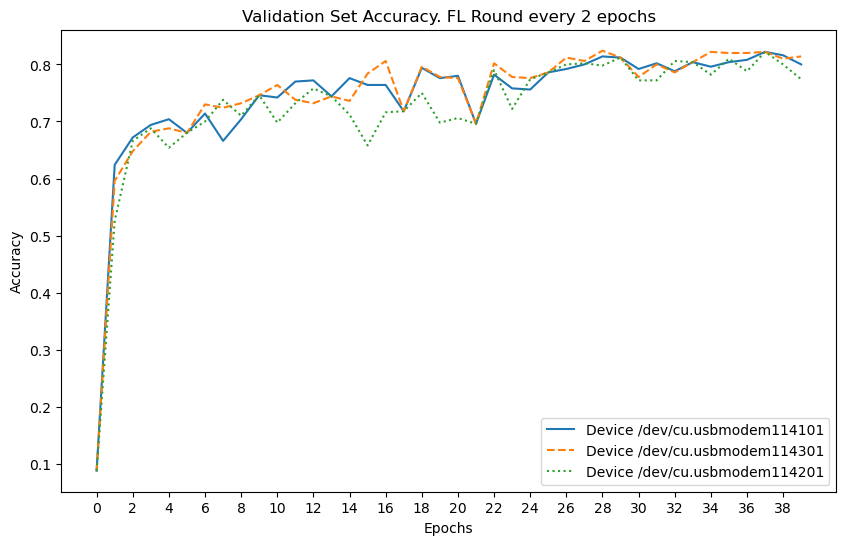

In [195]:
import matplotlib.pyplot as plt
line_styles = ['-', '--', ':', '-.']
markers = ['o', 's', 'D', '^']

plt.figure(figsize=(10,6))
for i,device in enumerate(all_devices_accuracies):
    linestyle = line_styles[i % len(line_styles)]
    marker = markers[i % len(markers)]
    plt.plot(all_devices_accuracies[device], label=f"Device {device}", linestyle=linestyle)

fl_rounds = epochs // fl_every_epoch
epochs_per_fl_round = fl_every_epoch
total_epochs = fl_rounds * epochs_per_fl_round

# Add vertical lines to separate FL rounds
#for i in range(1, fl_rounds):
    #plt.axvline(i * epochs_per_fl_round, color='gray', linestyle='--')

    
plt.xticks(range(0,len(fl_info_infer),2))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Set Accuracy. FL Round every 2 epochs')
plt.legend()
plt.show()

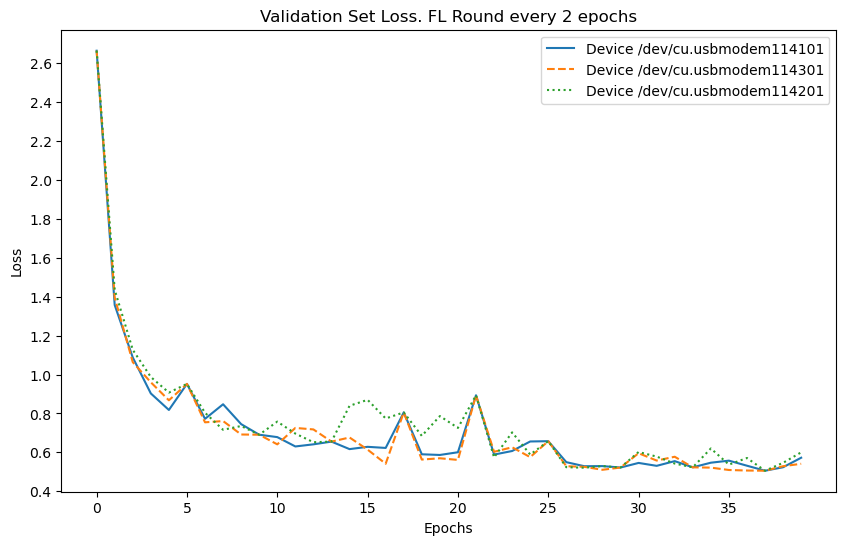

In [196]:
import matplotlib.pyplot as plt
line_styles = ['-', '--', ':', '-.']
markers = ['o', 's', 'D', '^']

plt.figure(figsize=(10,6))
for i,device in enumerate(all_devices_valid_loss):
    linestyle = line_styles[i % len(line_styles)]
    marker = markers[i % len(markers)]
    plt.plot(all_devices_valid_loss[device], label=f"Device {device}", linestyle=linestyle)

fl_rounds = epochs // fl_every_epoch
epochs_per_fl_round = fl_every_epoch
total_epochs = fl_rounds * epochs_per_fl_round

# Add vertical lines to separate FL rounds
#for i in range(1, fl_rounds):
    #plt.axvline(i * epochs_per_fl_round, color='gray', linestyle='--')
    
y_locator = ticker.MultipleLocator(base=0.2)  # Adjust the base value as needed
plt.gca().yaxis.set_major_locator(y_locator)
    
plt.xticks(range(0,len(fl_info_infer),5))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Set Loss. FL Round every 2 epochs')
plt.legend()
plt.show()

In [341]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

# Define the subset size
subset_size = 5000

# Load the CIFAR-10 dataset
(train_images, train_labels), (_, _) = cifar10.load_data()

# Create a subset of the dataset
subset_images = train_images[:subset_size]
subset_labels = train_labels[:subset_size]

# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
# Split the subset into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(
    subset_images, subset_labels, test_size=0.1, random_state=42)

# Perform desired operations on the subset of images
# ...

# Preprocess the data
X_train = train_images / 255.0
X_test = test_images / 255.0
Y_train = np_utils.to_categorical(train_labels, 10)
Y_test = np_utils.to_categorical(test_labels, 10)

# Example: Print the shape of the training and testing sets
print("Training Images Shape:", X_train.shape)
print("Training Labels Shape:", Y_train.shape)
print("Testing Images Shape:", X_test.shape)
print("Testing Labels Shape:", Y_test.shape)

Training Images Shape: (4500, 32, 32, 3)
Training Labels Shape: (4500, 10)
Testing Images Shape: (500, 32, 32, 3)
Testing Labels Shape: (500, 10)


## Iris dataset

In [268]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

# One hot encoding
enc = OneHotEncoder()
Y = enc.fit_transform(y[:, np.newaxis]).toarray()

# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.2, random_state=2)


### Keyword Spotting

In [59]:
import os
import json
# Keyword samples split
samples_folder = "./datasets/keywords_v3"
train_samples_split = 160 # Number of samples for training of each keyword
test_samples_split = 20   # Number of samples for training of each keyword
keywords_buttons = {
    "montserrat": 1,
    "pedraforca": 2,
    "vermell": 3,
    "blau": 4,
    #"verd": 5,
    # "up": 1,
    # "backward": 2,
    # "forward": 3,
    # "down": 4,
    # "left": 3,
    # "right": 4
}
def readKeyword(path_dir, keyword):
    with open(path_dir) as f:
        data = json.load(f)
        values = data['payload']['values']
        info = keyword.split('/')
        return info[0], values
import random
train_samples_split = 160 # Number of samples for training of each keyword
test_samples_split = 20   # Number of samples for training of each keyword

# Experiment sizes
training_epochs = 160   # Amount of training epochs. Can't be more than kws * train_samples_split
testing_epochs = 60     # Amount of test samples of each keyword. Can't be more than kws * test_samples_split

# Load the dataset
words = list(keywords_buttons.keys())
files = []
test_files = []
for i, word in enumerate(words):
    file_list = os.listdir(f"{samples_folder}/{word}")
    if (len(file_list) < train_samples_split + test_samples_split): 
        sys.exit(f"Not enough samples for keyword {word}")
    random.shuffle(file_list)
    files.append(list(map(lambda f: f"{word}/{f}", file_list[0:train_samples_split])))
    test_files.append(list(map(lambda f: f"{word}/{f}", file_list[train_samples_split:(train_samples_split+test_samples_split)])))

keywords = list(sum(zip(*files), ()))
test_keywords = list(sum(zip(*test_files), ()))

debug = True
if debug: print(f"Total available training keywords: {len(keywords)}")
if debug: print(f"Total available testing keywords: {len(test_keywords)}")
    
def get_x_y(data):
    ys = []
    xs = []
    train_names = []
    for keyword in data:
        info = keyword.split('/')
        train_names.append(info[0])

    train_names = set(train_names)
    test_names = []
    for keyword in test_keywords:
        info = keyword.split('/')
        test_names.append(info[0])

    test_names = set(test_names)
    name_to_int = {x:i for i,x in enumerate(test_names)}
    print(name_to_int)
    for keyword in data:
        name, values = readKeyword("./datasets/keywords_v3/" + keyword, keyword)
        ys.append(name_to_int[name])
        xs.append(values)
    return xs, ys

random.shuffle(keywords)
random.shuffle(test_keywords)
x_train, y_train = get_x_y(keywords)
x_test, y_test = get_x_y(test_keywords)

X_data = np.array(x_train).astype(np.float32)
X_data_test = np.array(x_test).astype(np.float32)
from keras.utils import np_utils
Y_train = np_utils.to_categorical(y_train, 4)
Y_test = np_utils.to_categorical(y_test, 4)
X_train = np.array(x_train)
X_test = np.array(x_test)

Total available training keywords: 640
Total available testing keywords: 80
{'pedraforca': 0, 'vermell': 1, 'blau': 2, 'montserrat': 3}
{'pedraforca': 0, 'vermell': 1, 'blau': 2, 'montserrat': 3}


### Mnist dataset

In [993]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
from keras.utils import np_utils
(X_train, y_train), (X_test, y_test) = mnist.load_data()

n_classes = 10
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape


Shape before one-hot encoding:  (60000,)


((60000, 28, 28), (60000, 10), (10000, 28, 28), (10000, 10))

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

datos = pd.read_csv("creditcard.csv")
datos.drop(['Time'], axis=1, inplace=True)
datos['Amount'] = StandardScaler().fit_transform(datos['Amount'].values.reshape(-1,1))

X_train, X_test = train_test_split(datos[:5000], test_size=0.2, random_state=42)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
X_train = X_train.values

Y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_test = X_test.values


In [18]:
X_train.shape, X_test.shape

((3998, 29), (1000, 29))

## Anomaly detection dataset

In [1094]:
import pandas as pd
import json

# Read the JSON file
with open("datasets_2/stateMonitors.json", "r") as file:
    data = json.load(file)

# Normalize the JSON data
df = pd.json_normalize(data, max_level=20)

# Display the first few rows of the DataFrame
df.head()


,date,payload.appPortDst,payload.appPortSrc,payload.messageId,payload.addrSrc,payload.addrDst,payload.messageSize,payload.simCommand,payload.state.Id,payload.state.Type,...,payload.state.SSS,payload.state.FMA,payload.state.packetHeader.Type,payload.state.packetHeader.Id,payload.state.packetHeader.Size,payload.state.packetHeader.Src,payload.state.packetHeader.Dst,payload.state.packetHeader.Via,payload.state.packetHeader.SeqId,payload.state.packetHeader.Num
0,25/05/2023 18:21:50,8,12,0,25516,0,53,2,0,0,...,122,131652,4,1,44,22212,65535,0,0,0
1,25/05/2023 18:21:50,8,12,0,20068,0,53,2,0,0,...,121,136180,4,1,44,22212,65535,0,0,0
2,25/05/2023 18:21:50,8,12,1,25516,0,53,2,1,1,...,123,131556,4,1,44,25516,65535,0,0,0
3,25/05/2023 18:21:51,8,12,1,20068,0,53,2,1,0,...,122,136084,4,1,44,35872,65535,0,0,0
4,25/05/2023 18:21:51,8,12,2,25516,0,53,2,2,0,...,123,131368,4,1,44,35872,65535,0,0,0


In [1096]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2305 entries, 0 to 2304
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   date                              2305 non-null   object
 1   payload.appPortDst                2305 non-null   int64 
 2   payload.appPortSrc                2305 non-null   int64 
 3   payload.messageId                 2305 non-null   int64 
 4   payload.addrSrc                   2305 non-null   int64 
 5   payload.addrDst                   2305 non-null   int64 
 6   payload.messageSize               2305 non-null   int64 
 7   payload.simCommand                2305 non-null   int64 
 8   payload.state.Id                  2305 non-null   int64 
 9   payload.state.Type                2305 non-null   int64 
 10  payload.state.QR                  2305 non-null   int64 
 11  payload.state.QS                  2305 non-null   int64 
 12  payload.state.QRU   

In [61]:
from sklearn.preprocessing import MinMaxScaler

Is important to normalize data for faster converge and better performance during training.
the range of the input values is important due to the activation function used in our models, these functions are sensitive to the input values. When values are big the gradient of activation functions may become 0 or unstable depending on the activation function used. Normalizing the input values help preventing this problem.

In [62]:
# Initialize the scaler
scaler = MinMaxScaler()

# Normalize the dataset
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [64]:
normalized_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354 entries, 0 to 353
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  354 non-null    float64
 1   Type                354 non-null    float64
 2   QR                  354 non-null    float64
 3   QS                  354 non-null    float64
 4   QRU                 354 non-null    float64
 5   QWRP                354 non-null    float64
 6   QWSP                354 non-null    float64
 7   RT                  354 non-null    float64
 8   SSS                 354 non-null    float64
 9   FMA                 354 non-null    float64
 10  packetHeader/Type   354 non-null    float64
 11  packetHeader/Id     354 non-null    float64
 12  packetHeader/Size   354 non-null    float64
 13  packetHeader/Src    354 non-null    float64
 14  packetHeader/Dst    354 non-null    float64
 15  packetHeader/Via    354 non-null    float64
 16  packetHe

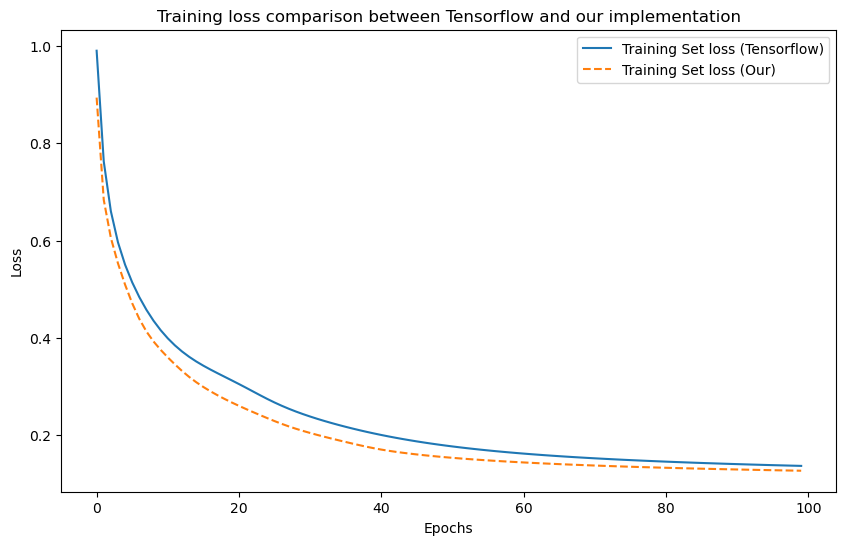

In [44]:
import matplotlib.pyplot as plt
line_styles = ['-', '--', ':', '-.']
markers = ['o', 's', 'D', '^']

train_loss = [0.9903568029403687, 0.7628063559532166, 0.6603224873542786, 0.5963509678840637, 0.550324022769928, 0.5140912532806396, 0.48372766375541687, 0.45763322710990906, 0.4351411759853363, 0.4157593548297882, 0.39903658628463745, 0.38457220792770386, 0.37202438712120056, 0.36108335852622986, 0.35144245624542236, 0.3427945077419281, 0.3348226249217987, 0.32725995779037476, 0.3198816776275635, 0.31251803040504456, 0.30504801869392395, 0.29740968346595764, 0.28963565826416016, 0.281857430934906, 0.2743019461631775, 0.26714131236076355, 0.2604750096797943, 0.25429269671440125, 0.24856789410114288, 0.24325016140937805, 0.23828306794166565, 0.2335939258337021, 0.22916793823242188, 0.224958598613739, 0.2209472954273224, 0.2171127200126648, 0.2134474366903305, 0.20994344353675842, 0.20659245550632477, 0.20340318977832794, 0.2003507763147354, 0.19744479656219482, 0.19467945396900177, 0.19203835725784302, 0.18953904509544373, 0.18714188039302826, 0.1848699450492859, 0.18269936740398407, 0.18063409626483917, 0.17865969240665436, 0.1767892837524414, 0.1749924272298813, 0.17328234016895294, 0.17165791988372803, 0.1700926572084427, 0.16861282289028168, 0.16718128323554993, 0.16582681238651276, 0.16451911628246307, 0.16327576339244843, 0.16207481920719147, 0.16092516481876373, 0.1598297357559204, 0.15876491367816925, 0.1577521711587906, 0.15677116811275482, 0.1558302342891693, 0.15491488575935364, 0.15404149889945984, 0.15319731831550598, 0.1523822546005249, 0.15159259736537933, 0.15083417296409607, 0.15009735524654388, 0.14938101172447205, 0.1487015038728714, 0.14803771674633026, 0.14738653600215912, 0.14675238728523254, 0.14614391326904297, 0.14553961157798767, 0.14497508108615875, 0.14441892504692078, 0.14387443661689758, 0.14333480596542358, 0.14282144606113434, 0.1423216015100479, 0.14184080064296722, 0.14135263860225677, 0.1408940702676773, 0.1404464989900589, 0.14000220596790314, 0.13956093788146973, 0.13914571702480316, 0.13872972130775452, 0.13832083344459534, 0.1379481852054596, 0.1375560760498047, 0.13718537986278534, 0.13681328296661377]
train_loss_our = [0.893958, 0.683724, 0.605558, 0.553129, 0.509275, 0.471062, 0.438919, 0.413044, 0.392509, 0.375337, 0.359901, 0.345466, 0.331999, 0.319757, 0.308808, 0.299001, 0.290106, 0.281923, 0.274283, 0.267073, 0.260225, 0.253653, 0.247280, 0.241026, 0.234877, 0.228911, 0.223255, 0.218007, 0.213176, 0.208691, 0.204488, 0.200503, 0.196695, 0.193021, 0.189441, 0.185942, 0.182499, 0.179155, 0.175961, 0.173004, 0.170329, 0.167937, 0.165786, 0.163820, 0.162014, 0.160333, 0.158767, 0.157299, 0.155914, 0.154615, 0.153381, 0.152213, 0.151102, 0.150049, 0.149047, 0.148089, 0.147174, 0.146299, 0.145461, 0.144657, 0.143888, 0.143148, 0.142425, 0.141737, 0.141072, 0.140432, 0.139814, 0.139217, 0.138639, 0.138078, 0.137537, 0.137013, 0.136504, 0.136011, 0.135532, 0.135067, 0.134615, 0.134178, 0.133751, 0.133336, 0.132931, 0.132538, 0.132156, 0.131783, 0.131419, 0.131064, 0.130717, 0.130380, 0.130051, 0.129729, 0.129414, 0.129108, 0.128806, 0.128512, 0.128224, 0.127943, 0.127667, 0.127397, 0.127133, 0.126875]

plt.figure(figsize=(10,6))
marker = markers[0]
plt.plot(train_loss, label=f"Training Set loss (Tensorflow)", linestyle=line_styles[0])
plt.plot(train_loss_our, label=f"Training Set loss (Our)", linestyle=line_styles[1])
   
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss comparison between Tensorflow and our implementation')
plt.legend()
plt.show()

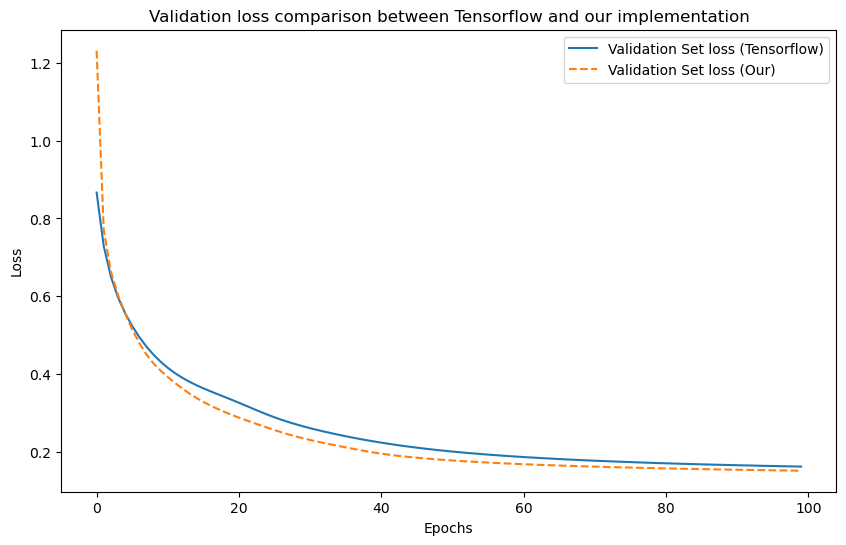

In [45]:
import matplotlib.pyplot as plt
line_styles = ['-', '--', ':', '-.']
markers = ['o', 's', 'D', '^']


val_loss = [0.8664199113845825, 0.7288760542869568, 0.6508371829986572, 0.5974512100219727, 0.556911051273346, 0.5237330794334412, 0.4954395592212677, 0.47106876969337463, 0.4500870406627655, 0.43202877044677734, 0.4164634644985199, 0.40300053358078003, 0.39133524894714355, 0.38114428520202637, 0.37211424112319946, 0.3639167249202728, 0.3562548756599426, 0.3488837778568268, 0.34160271286964417, 0.33426427841186523, 0.3267759382724762, 0.31909939646720886, 0.3113444447517395, 0.3036612868309021, 0.2963052988052368, 0.2894035279750824, 0.2829681932926178, 0.27703648805618286, 0.27154436707496643, 0.2664000391960144, 0.2615760564804077, 0.2570231556892395, 0.25272515416145325, 0.248594269156456, 0.24466411769390106, 0.24088312685489655, 0.23728574812412262, 0.23381318151950836, 0.23052582144737244, 0.22738462686538696, 0.22441959381103516, 0.22156354784965515, 0.21886996924877167, 0.21626898646354675, 0.21381914615631104, 0.21151606738567352, 0.20929396152496338, 0.20719914138317108, 0.20520275831222534, 0.20331917703151703, 0.20152054727077484, 0.19979587197303772, 0.19813001155853271, 0.19661632180213928, 0.19516155123710632, 0.19371406733989716, 0.19243638217449188, 0.19103577733039856, 0.18980772793293, 0.1886083036661148, 0.18745942413806915, 0.18637330830097198, 0.185330331325531, 0.18426814675331116, 0.18330702185630798, 0.18231301009655, 0.1814034879207611, 0.1804947853088379, 0.17965732514858246, 0.1788540780544281, 0.17804144322872162, 0.17727400362491608, 0.17661501467227936, 0.17586462199687958, 0.17517629265785217, 0.17448416352272034, 0.1738056093454361, 0.17322824895381927, 0.17256750166416168, 0.17193308472633362, 0.1714223474264145, 0.17081686854362488, 0.17029894888401031, 0.16980122029781342, 0.16923782229423523, 0.16870012879371643, 0.168229877948761, 0.16781441867351532, 0.1673336625099182, 0.16689909994602203, 0.1664421707391739, 0.16597846150398254, 0.16572275757789612, 0.16519030928611755, 0.16478584706783295, 0.1645079255104065, 0.16401246190071106, 0.16366077959537506, 0.16331592202186584, 0.1629415601491928]
val_loss_our = [1.230570, 0.770017, 0.663738, 0.603166, 0.556088, 0.515023, 0.479747, 0.450722, 0.427717, 0.409084, 0.392869, 0.377904, 0.363857, 0.350932, 0.339320, 0.328948, 0.319607, 0.311063, 0.303142, 0.295692, 0.288628, 0.281900, 0.275419, 0.269094, 0.262863, 0.256750, 0.250878, 0.245384, 0.240321, 0.235646, 0.231285, 0.227174, 0.223255, 0.219488, 0.215837, 0.212267, 0.208766, 0.205342, 0.202038, 0.198941, 0.196126, 0.193611, 0.191365, 0.189333, 0.187470, 0.185748, 0.184144, 0.182637, 0.181223, 0.179896, 0.178640, 0.177456, 0.176331, 0.175262, 0.174248, 0.173281, 0.172360, 0.171484, 0.170645, 0.169845, 0.169077, 0.168344, 0.167641, 0.166954, 0.166302, 0.165669, 0.165060, 0.164471, 0.163900, 0.163348, 0.162812, 0.162292, 0.161789, 0.161301, 0.160828, 0.160371, 0.159926, 0.159497, 0.159081, 0.158676, 0.158281, 0.157899, 0.157526, 0.157161, 0.156807, 0.156461, 0.156123, 0.155793, 0.155470, 0.155155, 0.154847, 0.154546, 0.154250, 0.153962, 0.153679, 0.153400, 0.153128, 0.152861, 0.152600, 0.152343]

plt.figure(figsize=(10,6))
marker = markers[0]
plt.plot(val_loss, label=f"Validation Set loss (Tensorflow)", linestyle=line_styles[0])
plt.plot(val_loss_our, label=f"Validation Set loss (Our)", linestyle=line_styles[1])
   
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation loss comparison between Tensorflow and our implementation')
plt.legend()
plt.show()

In [ ]:
cnn_valid_tf = [0.21848034858703613, 0.1437973529100418, 0.11280103772878647, 0.09034352749586105, 0.08687180280685425, 0.07897087931632996, 0.07881997525691986, 0.07366442680358887, 0.06859507411718369, 0.06733980774879456, 0.06398254632949829, 0.0691317468881607, 0.06345953047275543, 0.057599250227212906, 0.05789942666888237, 0.06646180152893066, 0.05904307961463928, 0.06256557255983353, 0.05541553348302841, 0.055995527654886246, 0.05669771134853363, 0.05645587667822838, 0.05414196848869324, 0.05653410777449608, 0.053415361791849136, 0.05904849246144295, 0.05773834139108658, 0.05499989539384842, 0.05554388463497162, 0.059184808284044266, 0.056101758033037186, 0.05850554630160332, 0.0582786425948143, 0.059940729290246964, 0.050419602543115616, 0.05906102806329727, 0.05324019119143486, 0.05527801066637039, 0.05684319883584976, 0.053868163377046585, 0.056612927466630936, 0.0548669807612896, 0.059645410627126694, 0.05139223486185074, 0.055304497480392456, 0.06023583933711052, 0.05260230228304863, 0.05323423445224762, 0.053582411259412766, 0.05505114793777466, 0.057623621076345444, 0.056282252073287964, 0.055649980902671814, 0.052225787192583084, 0.056390974670648575, 0.054085083305835724, 0.05834873020648956, 0.05673611909151077, 0.05578933283686638, 0.058263421058654785, 0.05259609967470169, 0.05622631683945656, 0.0611502006649971, 0.05533025413751602, 0.055094584822654724, 0.05577748268842697, 0.05515044555068016, 0.05506435036659241, 0.055146776139736176, 0.0552290603518486, 0.056463390588760376, 0.05673900246620178, 0.0576544813811779, 0.0571356937289238, 0.05770120397210121, 0.0572972297668457, 0.056707341223955154, 0.05788480117917061, 0.05768539384007454, 0.056215234100818634, 0.060948193073272705, 0.057697843760252, 0.058830976486206055, 0.05939805135130882, 0.060082897543907166, 0.056624121963977814, 0.05785224586725235, 0.05685444176197052, 0.05836649239063263, 0.05785844102501869, 0.05795498192310333, 0.05758903920650482, 0.05981667339801788, 0.058029308915138245, 0.05793704837560654, 0.059250205755233765, 0.058112792670726776, 0.05828135833144188, 0.058318842202425, 0.056488603353500366]
cnn_train_tf = [0.5915535092353821, 0.17271727323532104, 0.12857839465141296, 0.10503339767456055, 0.09315040707588196, 0.08412138372659683, 0.079491525888443, 0.07169309258460999, 0.06716097146272659, 0.06433694064617157, 0.06042487919330597, 0.05717138200998306, 0.05581904575228691, 0.05405057594180107, 0.04923480749130249, 0.04874063655734062, 0.04535014554858208, 0.04412306472659111, 0.04302501678466797, 0.04276011511683464, 0.03922915831208229, 0.036927442997694016, 0.035117119550704956, 0.03367925435304642, 0.032168198376894, 0.03218202665448189, 0.03277328982949257, 0.03391849622130394, 0.02940519154071808, 0.028941581025719643, 0.027746591717004776, 0.02688169851899147, 0.02690940909087658, 0.026401318609714508, 0.025742633268237114, 0.023516563698649406, 0.02344449795782566, 0.023209810256958008, 0.02269790694117546, 0.022717077285051346, 0.019658228382468224, 0.019382383674383163, 0.01932947337627411, 0.019247673451900482, 0.01811133697628975, 0.017265425994992256, 0.019570453092455864, 0.016566647216677666, 0.015622514300048351, 0.01574467308819294, 0.014531685039401054, 0.01552104763686657, 0.014788857661187649, 0.014537392184138298, 0.013846919871866703, 0.013058184646070004, 0.011966410093009472, 0.012344352900981903, 0.011498955078423023, 0.0108367083594203, 0.010798418894410133, 0.010992597788572311, 0.013778474181890488, 0.012088503688573837, 0.010204910300672054, 0.009804636240005493, 0.009154542349278927, 0.008909089490771294, 0.009249554015696049, 0.008859405294060707, 0.007896809838712215, 0.007621555123478174, 0.007611350622028112, 0.009001288563013077, 0.008342684246599674, 0.007554497104138136, 0.007459802553057671, 0.007079777307808399, 0.006805106066167355, 0.006531857885420322, 0.006493932101875544, 0.005914083682000637, 0.005753582343459129, 0.005646183621138334, 0.005398968700319529, 0.005160376895219088, 0.005171061493456364, 0.005031037610024214, 0.004832217004150152, 0.004686493426561356, 0.0047033014707267284, 0.004325464367866516, 0.0043526035733520985, 0.00417504133656621, 0.004075608681887388, 0.003889727173373103, 0.0038834011647850275, 0.004001007881015539, 0.003911340609192848, 0.0038985731080174446]

cnn_valid_acc = [0.9401000142097473, 0.9570000171661377, 0.9672999978065491, 0.9732000231742859, 0.9728999733924866, 0.9735999703407288, 0.9761000275611877, 0.9779999852180481, 0.9789000153541565, 0.9794999957084656, 0.9790999889373779, 0.9772999882698059, 0.9799000024795532, 0.9815000295639038, 0.9815000295639038, 0.978600025177002, 0.98089998960495, 0.9796000123023987, 0.9836000204086304, 0.9821000099182129, 0.9825000166893005, 0.9819999933242798, 0.9836000204086304, 0.9818000197410583, 0.9822999835014343, 0.982200026512146, 0.9815999865531921, 0.9812999963760376, 0.9817000031471252, 0.98089998960495, 0.9836000204086304, 0.982200026512146, 0.9824000000953674, 0.9807999730110168, 0.9825999736785889, 0.9811000227928162, 0.9829999804496765, 0.9836000204086304, 0.9821000099182129, 0.9817000031471252, 0.9812999963760376, 0.982699990272522, 0.98089998960495, 0.983299970626831, 0.982699990272522, 0.9803000092506409, 0.9829999804496765, 0.9839000105857849, 0.982699990272522, 0.9825000166893005, 0.9818999767303467, 0.9807999730110168, 0.9828000068664551, 0.982699990272522, 0.9814000129699707, 0.9825999736785889, 0.9815000295639038, 0.9824000000953674, 0.9818000197410583, 0.9817000031471252, 0.9842000007629395, 0.982699990272522, 0.9810000061988831, 0.9828000068664551, 0.9836000204086304, 0.9835000038146973, 0.9836999773979187, 0.984000027179718, 0.9824000000953674, 0.9828000068664551, 0.9828000068664551, 0.9822999835014343, 0.9825999736785889, 0.983299970626831, 0.984499990940094, 0.9836000204086304, 0.9836000204086304, 0.983299970626831, 0.9829999804496765, 0.982699990272522, 0.982699990272522, 0.9825000166893005, 0.982699990272522, 0.9818999767303467, 0.9822999835014343, 0.983299970626831, 0.9824000000953674, 0.9824000000953674, 0.982699990272522, 0.9832000136375427, 0.9833999872207642, 0.9822999835014343, 0.9825000166893005, 0.982200026512146, 0.9824000000953674, 0.9828000068664551, 0.9829000234603882, 0.9829999804496765, 0.9828000068664551, 0.9828000068664551]
cnn_train_acc = [0.8519666790962219, 0.95128333568573, 0.9625666737556458, 0.9691166877746582, 0.9722499847412109, 0.9757999777793884, 0.9763500094413757, 0.9785000085830688, 0.9801666736602783, 0.9803666472434998, 0.9819833040237427, 0.982616662979126, 0.982866644859314, 0.9838333129882812, 0.9853500127792358, 0.9852166771888733, 0.9865166544914246, 0.9865999817848206, 0.9872666597366333, 0.9870666861534119, 0.9883166551589966, 0.9889000058174133, 0.989883303642273, 0.9898499846458435, 0.9908666610717773, 0.9906833171844482, 0.9900500178337097, 0.9897333383560181, 0.9913666844367981, 0.9911500215530396, 0.9918500185012817, 0.9925500154495239, 0.9922500252723694, 0.9926166534423828, 0.9922833442687988, 0.9933833479881287, 0.9934499859809875, 0.9932833313941956, 0.9939166903495789, 0.9935833215713501, 0.9950166940689087, 0.9947333335876465, 0.9944333434104919, 0.9948999881744385, 0.9952666759490967, 0.9955666661262512, 0.9944000244140625, 0.9958833456039429, 0.9961333274841309, 0.996066689491272, 0.996666669845581, 0.9960833191871643, 0.996566653251648, 0.9964666962623596, 0.9968500137329102, 0.9970333576202393, 0.9974499940872192, 0.9971666932106018, 0.9975000023841858, 0.9977166652679443, 0.9977166652679443, 0.9978166818618774, 0.9965833425521851, 0.9970999956130981, 0.998116672039032, 0.9981499910354614, 0.9986166954040527, 0.998533308506012, 0.9982500076293945, 0.9985666871070862, 0.9990000128746033, 0.9991333484649658, 0.9989833235740662, 0.9984333515167236, 0.9985833168029785, 0.9990333318710327, 0.9988499879837036, 0.9989666938781738, 0.9990333318710327, 0.9993333220481873, 0.9993166923522949, 0.9994166493415833, 0.9994000196456909, 0.9994666576385498, 0.9995333552360535, 0.9995833039283752, 0.9995499849319458, 0.9995333552360535, 0.9995833039283752, 0.999666690826416, 0.9997166395187378, 0.9998000264167786, 0.9996833205223083, 0.9997666478157043, 0.999833345413208, 0.9998000264167786, 0.9998166561126709, 0.9998000264167786, 0.9997833371162415, 0.999833345413208]

In [56]:
# TENSORFLOW

loss = [1.959566593170166, 1.227865219116211, 0.8419866561889648, 0.638801634311676, 0.5150259137153625, 0.4311065375804901, 0.37486109137535095, 0.3352672755718231, 0.304882675409317, 0.2817482054233551, 0.26331955194473267, 0.24746952950954437, 0.23516309261322021, 0.22400596737861633, 0.21401162445545197, 0.205986887216568, 0.19834379851818085, 0.19154666364192963, 0.1854851245880127, 0.18004532158374786, 0.17504964768886566, 0.1708144098520279, 0.16683049499988556, 0.16242073476314545, 0.15867090225219727]
val_loss = [1.5231969356536865, 0.984671413898468, 0.7122002840042114, 0.5565064549446106, 0.4570382833480835, 0.38568931818008423, 0.33854204416275024, 0.3068647086620331, 0.28120529651641846, 0.2608382999897003, 0.24407897889614105, 0.23009982705116272, 0.22249464690685272, 0.20964328944683075, 0.2000943124294281, 0.19414077699184418, 0.18749675154685974, 0.18052147328853607, 0.17919358611106873, 0.17418721318244934, 0.16909334063529968, 0.1646670550107956, 0.16063827276229858, 0.1572045236825943, 0.15271161496639252]
acc = [0.46753332018852234, 0.7347999811172485, 0.8258833289146423, 0.862416684627533, 0.884066641330719, 0.8995166420936584, 0.9095333218574524, 0.9171666502952576, 0.923466682434082, 0.9282833337783813, 0.9318333268165588, 0.9362333416938782, 0.9379833340644836, 0.941016674041748, 0.9429833292961121, 0.9452999830245972, 0.9469333291053772, 0.9483833312988281, 0.9497500061988831, 0.9516333341598511, 0.9527333378791809, 0.9531499743461609, 0.9542166590690613, 0.9559999704360962, 0.956250011920929]
val_acc = [0.6567000150680542, 0.8055999875068665, 0.855400025844574, 0.8838000297546387, 0.900600016117096, 0.9108999967575073, 0.9204999804496765, 0.9264000058174133, 0.9301000237464905, 0.9319000244140625, 0.9369000196456909, 0.9399999976158142, 0.9419000148773193, 0.944599986076355, 0.946399986743927, 0.9472000002861023, 0.9506999850273132, 0.9506000280380249, 0.9501000046730042, 0.95169997215271, 0.9524999856948853, 0.9539999961853027, 0.9553999900817871, 0.95660001039505, 0.9578999876976013]


# OUR

val_acc_our = [0.842400, 0.893000, 0.907300, 0.917600, 0.927900, 0.932000, 0.936700, 0.941500, 0.942100, 0.946400, 0.947000, 0.951800, 0.952200, 0.951800, 0.953900, 0.953000, 0.955600, 0.954400, 0.953300, 0.958500, 0.958600, 0.958900, 0.958900, 0.958800, 0.960600]
val_loss_our = [0.575744,0.400884,0.341084,0.307212,0.264596,0.257206,0.227454,0.216053,0.211022,0.195401,0.190579,0.179105,0.174914,0.176110,0.170826,0.166402,0.163560,0.164187,0.163799,0.152433,0.146564,0.142888,0.142839,0.143701,0.139428]

acc_our = [0.698150, 0.859900, 0.896233, 0.910050, 0.916933, 0.922400, 0.928450, 0.934583, 0.938067, 0.940767, 0.944167, 0.946517, 0.949050, 0.948867, 0.948167, 0.950617, 0.952033, 0.953200, 0.952500, 0.955883, 0.956167, 0.957017, 0.957533, 0.957083, 0.957633]
loss_our = [0.987681, 0.498099, 0.380210, 0.327054, 0.303201, 0.282063, 0.257978, 0.239724, 0.224569, 0.214351, 0.202987, 0.193813, 0.186628, 0.182487, 0.184277, 0.178243, 0.169962, 0.166654, 0.167948, 0.158082, 0.154703, 0.150368, 0.149334, 0.149072, 0.148101]

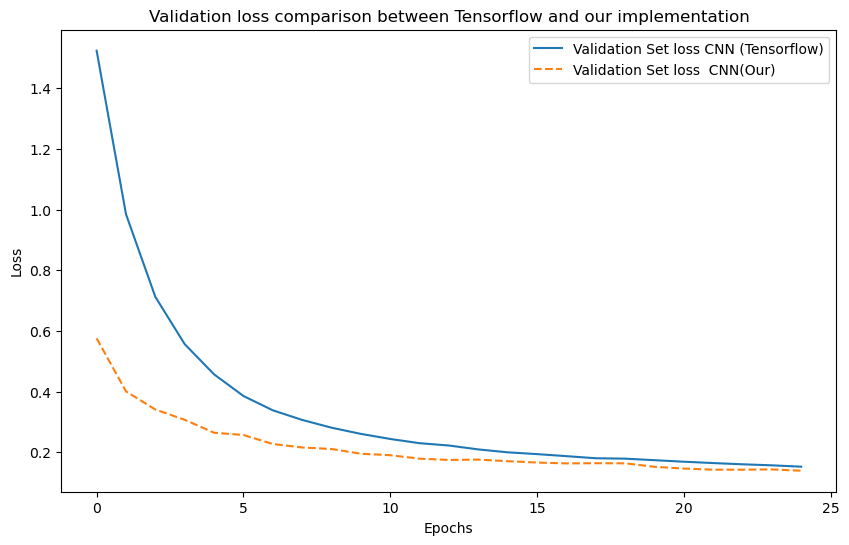

In [57]:
import matplotlib.pyplot as plt
line_styles = ['-', '--', ':', '-.']
markers = ['o', 's', 'D', '^']

plt.figure(figsize=(10,6))
marker = markers[0]
plt.plot(val_loss, label=f"Validation Set loss CNN (Tensorflow)", linestyle=line_styles[0])
plt.plot(val_loss_our, label=f"Validation Set loss  CNN(Our)", linestyle=line_styles[1])
   
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation loss comparison between Tensorflow and our implementation')
plt.legend()
plt.show()

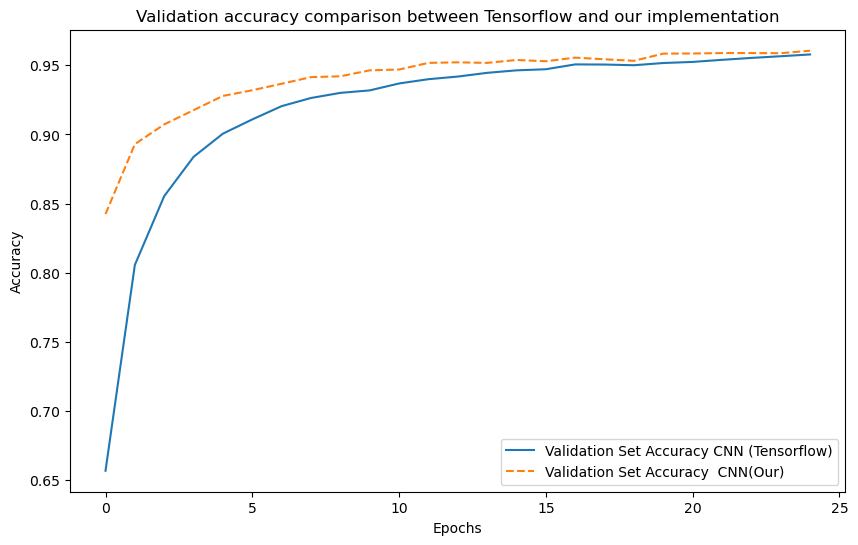

In [58]:
import matplotlib.pyplot as plt
line_styles = ['-', '--', ':', '-.']
markers = ['o', 's', 'D', '^']

plt.figure(figsize=(10,6))
marker = markers[0]
plt.plot(val_acc, label=f"Validation Set Accuracy CNN (Tensorflow)", linestyle=line_styles[0])
plt.plot(val_acc_our, label=f"Validation Set Accuracy  CNN(Our)", linestyle=line_styles[1])
   
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation accuracy comparison between Tensorflow and our implementation')
plt.legend()
plt.show()